In [1]:
import nltk
import urllib.request                   
from bs4 import BeautifulSoup           
import pandas as pd
from string import punctuation
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation

In [2]:
# NLTK's corpus of inaugural Presidential speeches
    
from nltk.corpus import inaugural
nltk.download('inaugural')
speech_name=inaugural.fileids()

[nltk_data] Downloading package inaugural to C:\Users\Vikanksha
[nltk_data]     Goley\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\inaugural.zip.


In [3]:
#Biden's speech

speech_name[-1]

'2021-Biden.txt'

In [4]:
#Getting party affiliation data from: https://www.britannica.com/topic/Presidents-of-the-United-States-1846696

import requests
url = 'https://www.britannica.com/topic/Presidents-of-the-United-States-1846696'
response = requests.get(url) 

soup = BeautifulSoup(response.text, 'html.parser')
len(soup.find_all('table'))

1

In [5]:
#Storing the table data and finding the number of rows

president_table = soup.find('table')
all_rows = president_table.find_all('tr')

# Read data from HTML table into arrays

data = []
for row in all_rows:
    cells = row.find_all('td')
    
    if len(cells)>1:
        president=cells[2].find(text=True)
        party=cells[4].find(text=True)
        if party != 'Democratic' and party != 'Republican':
            party = 'Other'
            
        data.append([president,party])

In [6]:
#Converting the list of president data into a dataframe

df = pd.DataFrame(data,columns=['name','party'])
df.head(2)

#Removing the president's data for whom speech is not present in the corpus.
df.set_index('name', inplace=True)
df.drop(['John Tyler','Millard Fillmore','Andrew Johnson','Chester A. Arthur','Gerald R. Ford'],axis=0,inplace=True)

df.reset_index(inplace=True)

partylist=df.values.tolist()

In [7]:
# Finding the required presidents details from scraped data

df2 = pd.DataFrame(columns=['name','year','party','text'])
row=0
for fileid in inaugural.fileids():   
    if  partylist[row][0].find(fileid[5:-4]) == -1:
        row = row+1
    # Add data to the Dataframe
    df2 = df2.append({'name': partylist[row][0],
                      'year': fileid[:4], 
                      'party': partylist[row][1],
                      'text': inaugural.raw(fileid)}, ignore_index=True)    

In [8]:
df2.head(2)

,name,year,party,text
0,George Washington,1789,Other,Fellow-Citizens of the Senate and of the House...
1,George Washington,1793,Other,"Fellow citizens, I am again called upon by the..."


In [9]:
df2.to_excel("Speech_Corpus.xlsx")

### Text Preprocessing

In [10]:
#Creating function to remove punctuation and converting the text to lower case.

def preprocess(speech):
    y=re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', ' ', speech).lower()
    return(y)

In [11]:
#Applying the function to preprocess the text
df2['Processed_Text'] = df2['text'].map(lambda x: preprocess(x))

# Getting all Words in each speech
df2['AllWords'] = df2['Processed_Text'].apply(lambda x: nltk.tokenize.word_tokenize(x))

# Number of words in each speech
df2['TotalWords_Count'] = df2['Processed_Text'].apply(lambda x: len(nltk.tokenize.word_tokenize(x)))

#First getting the frequency distribution, which gives the distinct words and their count.
df2['DistinctWords'] = df2['Processed_Text'].apply(lambda x: nltk.FreqDist(nltk.tokenize.word_tokenize(x)))

#Getting the distinct words from the keys of the above calculated frequency distribution.
df2['DistinctWords'] = df2['DistinctWords'].apply(lambda x: list(x.keys()))

#Finding the number of distinct words in each speech
df2['DistinctWords_Count'] = df2['DistinctWords'].apply(lambda x: len(x))

df2.head(2)

,name,year,party,text,Processed_Text,AllWords,TotalWords_Count,DistinctWords,DistinctWords_Count
0,George Washington,1789,Other,Fellow-Citizens of the Senate and of the House...,fellow citizens of the senate and of the house...,"[fellow, citizens, of, the, senate, and, of, t...",1431,"[fellow, citizens, of, the, senate, and, house...",594
1,George Washington,1793,Other,"Fellow citizens, I am again called upon by the...",fellow citizens i am again called upon by the...,"[fellow, citizens, i, am, again, called, upon,...",135,"[fellow, citizens, i, am, again, called, upon,...",90


### 1. Which president has the most vocabulary as evident from their inaugural speeches, and which presidents has the least vocabulary? On average, do Democratic, Republican, or Other presidents have higher vocabulary?

In [12]:
print("President with Maximum vocabulary: ")
print(df2[df2['DistinctWords_Count']==df2['DistinctWords_Count'].max()]['name'].to_string(index=False))

print("\nPresident with Minimum vocabulary: ")
print(df2[df2['DistinctWords_Count']==df2['DistinctWords_Count'].min()]['name'].to_string(index=False))

President with Maximum vocabulary: 
 William Henry Harrison

President with Minimum vocabulary: 
 George Washington


In [13]:
df_party = df2.groupby('party')

round(df_party['DistinctWords_Count'].mean(),2)

party
Democratic    706.13
Other         783.42
Republican    807.50
Name: DistinctWords_Count, dtype: float64

#### From the above result, we can see that the Republican Presidents have the highest average vocabulary.

### 2. Create a barplot of presidential vocabulary from the earliest president (Washington) to the latest (Trump) in this sample of presidential speeches. Color code this barplot as blue for Democrats, red for Republican, and gray for Others.

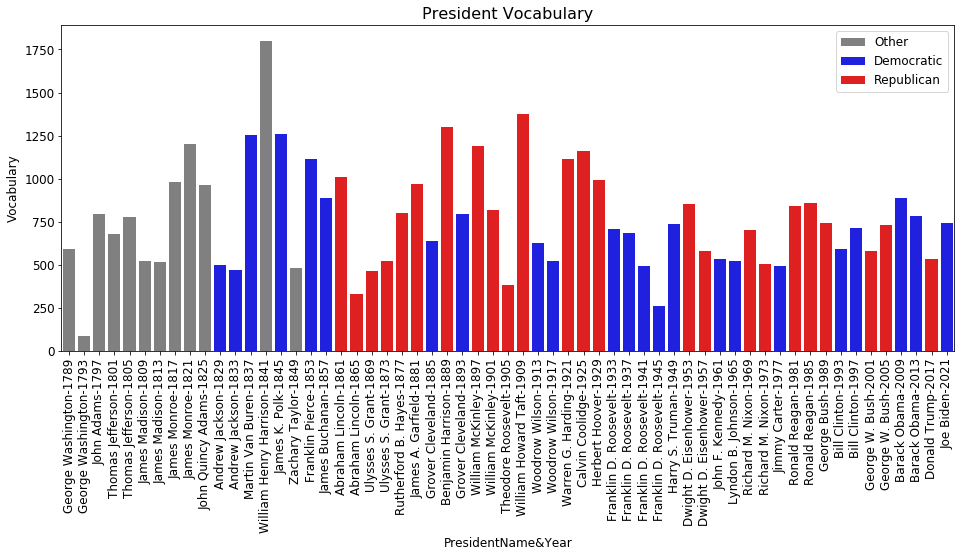

In [14]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation='vertical',fontsize = 12)
plt.yticks(fontsize = 12)

ax = sns.barplot(x = (df2['name'] + '-' + df2['year']), y='DistinctWords_Count', data = df2, hue="party", palette = ['grey', 'blue', 'red'],dodge=False, ci = True)

ax.set_title('President Vocabulary', fontsize=16)
ax.set_ylabel('Vocabulary', fontsize=12)
ax.set_xlabel('PresidentName&Year', fontsize=12)
ax.legend(loc='upper right',fontsize=12)
plt.show()

### 3. What are the five most frequently used words (exclusive of stop words) used by each president? Do Democratic presidents use a different set of words than Republican presidents?

In [15]:
stopw = nltk.corpus.stopwords.words('english')

In [16]:
# Removing stop words from speech

def excludeStopWords(words) :
    words = [w for w in words if w not in stopw]
    return words

df2['All_except_stopw'] = df2['AllWords'].map(lambda x: excludeStopWords(x))

df2['Frequency_all'] = df2['All_except_stopw'].apply(lambda x: nltk.FreqDist(x))

In [17]:
df2.head(2)

,name,year,party,text,Processed_Text,AllWords,TotalWords_Count,DistinctWords,DistinctWords_Count,All_except_stopw,Frequency_all
0,George Washington,1789,Other,Fellow-Citizens of the Senate and of the House...,fellow citizens of the senate and of the house...,"[fellow, citizens, of, the, senate, and, of, t...",1431,"[fellow, citizens, of, the, senate, and, house...",594,"[fellow, citizens, senate, house, representati...","{'fellow': 3, 'citizens': 5, 'senate': 1, 'hou..."
1,George Washington,1793,Other,"Fellow citizens, I am again called upon by the...",fellow citizens i am again called upon by the...,"[fellow, citizens, i, am, again, called, upon,...",135,"[fellow, citizens, i, am, again, called, upon,...",90,"[fellow, citizens, called, upon, voice, countr...","{'fellow': 1, 'citizens': 1, 'called': 1, 'upo..."


In [18]:
#Finding top five words

from collections import Counter 

def top_five(data):
    a=[]
    k= Counter(data) 
    high = k.most_common(5)
    for i in high:
        a.append(i[0])
    return a

df2['Top Five Used Words'] = df2['Frequency_all'].map(lambda x: top_five(x))

df2[['name','year','Top Five Used Words']].style.hide_index()

name,year,Top Five Used Words
George Washington,1789,"['every', 'government', 'public', 'may', 'citizens']"
George Washington,1793,"['shall', 'oath', 'fellow', 'citizens', 'called']"
John Adams,1797,"['people', 'government', 'may', 'nations', 'country']"
Thomas Jefferson,1801,"['government', 'us', 'may', 'fellow', 'citizens']"
Thomas Jefferson,1805,"['public', 'citizens', 'may', 'fellow', 'state']"
James Madison,1809,"['nations', 'public', 'well', 'country', 'peace']"
James Madison,1813,"['war', 'country', 'united', 'every', 'british']"
James Monroe,1817,"['government', 'great', 'states', 'people', 'us']"
James Monroe,1821,"['great', 'states', 'would', 'united', 'war']"
John Quincy Adams,1825,"['union', 'government', 'upon', 'country', 'rights']"


In [19]:
party_grp = df2.groupby('party')
other = party_grp.get_group('Other')
dem = party_grp.get_group('Democratic')
rep = party_grp.get_group('Republican')

dem_words=[]
for i in dem['All_except_stopw'] : 
    dem_words.extend(i) 

dem_freq=nltk.FreqDist(dem_words)

dem_top=top_five(dem_freq)
print("\nTop five words used by Democratic Presidents are:\n", dem_top)

rep_words=[]
for i in rep['All_except_stopw'] : 
    rep_words.extend(i) 

rep_freq=nltk.FreqDist(rep_words)

rep_top=top_five(rep_freq)
print("\nTop five words used by Republican Presidents are:\n", rep_top)


Top five words used by Democratic Presidents are:
 ['us', 'people', 'government', 'must', 'nation']

Top five words used by Republican Presidents are:
 ['people', 'government', 'us', 'must', 'world']


#### Based on the above analysis, out of the top five words used by Democratic and Republican presidents, four are same. We can say that there is not muh difference in the set of words used by presidents of both parties.

### 4. What are the key themes (e.g., freedom, liberty, etc.) used by each president in their inaugural speech?

In [20]:
def keythemes(data):
    
    #Getting the parts of speech using nltk
    parts=nltk.pos_tag(data)
    
    #Adding the result to a dataframe
    dfp=pd.DataFrame(parts, columns=('word','partofspeech'))
    
    #Key themes are noun words, hence, Extracting those rows which have part of speech as 'NN' or 'NNS'(noun)
    dfn=dfp[dfp['partofspeech'].isin(['NN', 'NNS'])]
    
    #Finding the top two most commonly used noun by the president
    f=nltk.FreqDist(dfn['word'])
    k= Counter(f) 
    high = k.most_common(2)
    a=[]
    for i in high:
        a.append(i[0])
    return a

In [21]:
df2['Key_Themes'] = df2['All_except_stopw'].map(lambda x: keythemes(x))
print('Key Themes used by each president in their inaugural speech are:')
df2[['name','Key_Themes']].style.hide_index()

Key Themes used by each president in their inaugural speech are:


name,Key_Themes
George Washington,"['government', 'citizens']"
George Washington,"['fellow', 'citizens']"
John Adams,"['people', 'government']"
Thomas Jefferson,"['government', 'citizens']"
Thomas Jefferson,"['citizens', 'state']"
James Madison,"['nations', 'country']"
James Madison,"['war', 'country']"
James Monroe,"['government', 'states']"
James Monroe,"['states', 'war']"
John Quincy Adams,"['union', 'government']"


### 5. Compute a sentiment (positive/negative) for each president, and draw three barplots of Democratic, Republican, and other presidents in chronological order. Which of these groups have higher mean sentiment score? Who are the top three presidents with the highest positive sentiment in each group?

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#Sentiment score for each president
for i in df2.index:
    speech_text = df2.loc[i, 'Processed_Text']
    sentiment = analyzer.polarity_scores(speech_text)
    polarity = sentiment['compound']
    df2.loc[i, 'polarity'] = polarity
    pos = sentiment['pos']
    df2.loc[i, 'positive'] = pos

# Grouping data based on party for polarities 
party_grp = df2.groupby('party')
other2 = party_grp.get_group('Other')
dem2 = party_grp.get_group('Democratic')
rep2 = party_grp.get_group('Republican')

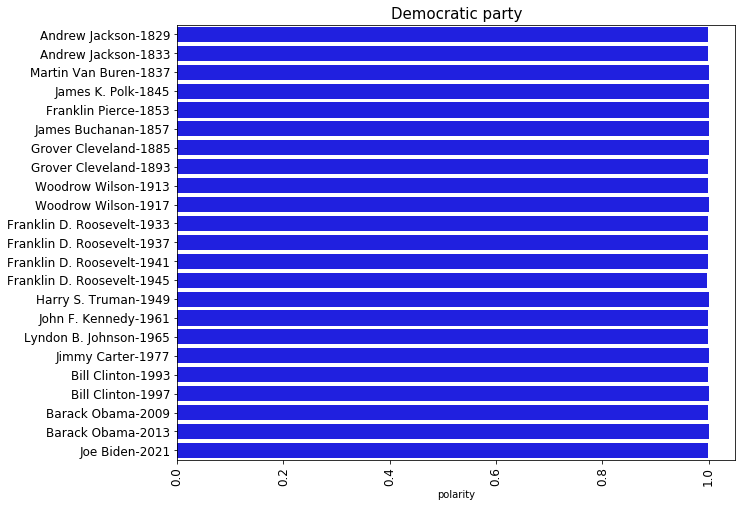

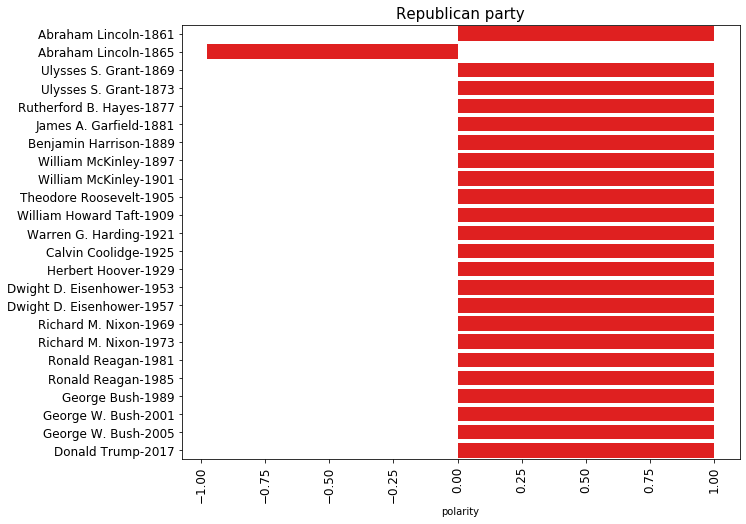

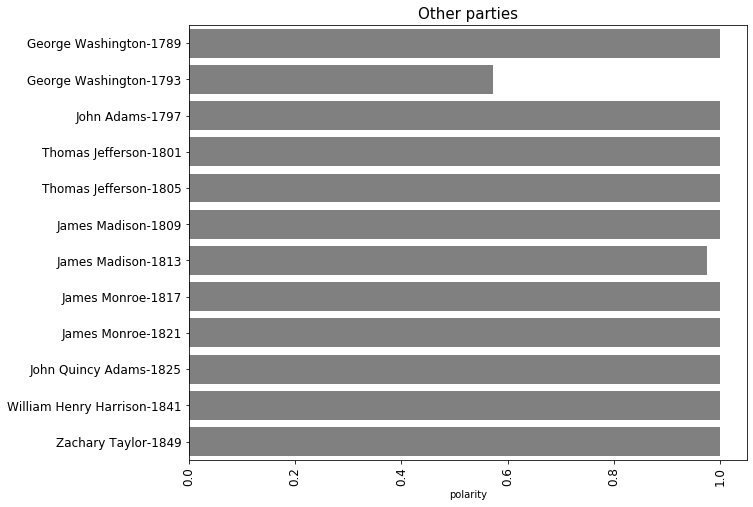

In [23]:
plt.figure(figsize=(10, 8))
sns.barplot(x=dem2['polarity'],y=(dem2['name']+'-'+dem2['year']), color='blue')
plt.xticks(rotation='vertical',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Democratic party',fontsize=15)
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(x=rep2['polarity'], y=(rep2['name']+'-'+rep2['year']), color='red')
plt.xticks(rotation='vertical',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Republican party',fontsize=15)
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(x=other2['polarity'], y=(other2['name']+'-'+other2['year']), color='grey')
plt.xticks(rotation='vertical',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Other parties',fontsize=15)
plt.show()

In [24]:
print('Mean sentiment score of each party:\n', round(party_grp['polarity'].mean(),2))

Mean sentiment score of each party:
 party
Democratic    1.00
Other         0.96
Republican    0.92
Name: polarity, dtype: float64


In [25]:
# Top 3 presidents with the highest positive sentiment for each party 

df3 = df2.drop_duplicates(['name'])
sort_df = df2.sort_values(by=['party', 'positive'],ascending=False)
sort_df = sort_df.groupby('party')['name', 'party', 'positive'].head(3)

print('Top 3 presidents with the highest positive sentiment for each party are: ')
sort_df.style.hide_index()

Top 3 presidents with the highest positive sentiment for each party are: 


name,party,positive
Dwight D. Eisenhower,Republican,0.273
George W. Bush,Republican,0.269
Dwight D. Eisenhower,Republican,0.263
John Adams,Other,0.258
George Washington,Other,0.239
Zachary Taylor,Other,0.238
Jimmy Carter,Democratic,0.285
Harry S. Truman,Democratic,0.283
Bill Clinton,Democratic,0.224
